# Mapping our studies

[![colab badge](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mcallaghan/NLP-climate-science-tutorial-CCAI/blob/main/H_mapping_results.ipynb)

Now that we have linked our studies to grid cells, we can plot the density of studies per grid cell on a map

In [1]:
import pandas as pd
import re
import os

## If we are running in colab, mount google drive and change into the directory we cloned the repository into
if os.path.exists("/content/"):
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/NLP-climate-science-tutorial-CCAI") 



# First we load the data and the predictions
from D_run_cv_experiments import load_data
df = load_data(False)
df.loc[pd.isna(df["id"]), "id"] = df.loc[pd.isna(df["id"]), "OA_id"]
df["id"] = df["id"].astype(str)

# Now we get the predictions, and filter only those likely to be relevant
df = (df
      .merge(pd.read_csv('cv_data/INCLUDE/predictions_5_splits.csv'), how="outer")
      .merge(pd.read_csv('cv_data/12/predictions_5_splits.csv'), how="outer")
     )
for pred_col in [x for x in df.columns if "_prediction" in x]:
    label_col = pred_col.replace("_prediction","")
    df.loc[pd.isna(df[pred_col]), pred_col] = df.loc[pd.isna(df[pred_col]),label_col]


df = df.loc[df["INCLUDE_prediction"]>=0.5]
print(df.shape)
df.head()

(14442, 21)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,...,OA_id,doi,publication_year,authors,INCLUDE_prediction,12 - Coastal and marine Ecosystems_prediction,12 - Human and managed_prediction,"12 - Mountains, snow and ice_prediction","12 - Rivers, lakes, and soil moisture_prediction",12 - Terrestrial ES_prediction
0,https://openalex.org/W2042376721,Using a global model of ocean biogeochemistry ...,Response of diatoms distribution to global war...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,https://openalex.org/W2042376721,https://doi.org/10.1029/2005gl023653,2005.0,"Laurent Bopp, Olivier Aumont, Patricia Cadule,...",0.515410,0.178558,0.229428,0.136585,0.207002,0.381199
1,https://openalex.org/W2169660258,"Prior to Euro‐American settlement, dry pondero...",Dry forests and wildland fires of the inland N...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,https://openalex.org/W2169660258,https://doi.org/10.1016/j.foreco.2005.02.016,2005.0,"Paul F. Hessburg, James K. Agee, Jerry F. Fran...",0.515282,0.179385,0.229489,0.136761,0.207190,0.379661
2,https://openalex.org/W2152100096,Recent reports show ethylene-dependent reducti...,"Drought, ozone, ABA and ethylene: new insights...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,https://openalex.org/W2152100096,https://doi.org/10.1111/j.1365-3040.2009.02052.x,2010.0,"Sally Wilkinson, William J. Davies",0.515207,0.178998,0.229423,0.136727,0.206997,0.380594
3,https://openalex.org/W1966512647,AbstractChanges to the Northern Hemisphere win...,Northern Hemisphere Extratropical Cyclones in ...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,https://openalex.org/W1966512647,https://doi.org/10.1175/2011jcli4181.1,2011.0,"Jennifer L. Catto, Len Shaffrey, Kevin I. Hodges",0.515316,0.178869,0.229420,0.136495,0.206756,0.381524
4,https://openalex.org/W2126066091,The assessment report of the 4th International...,Impact of naturally spawning captive-bred Atla...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,https://openalex.org/W2126066091,https://doi.org/10.1098/rspb.2009.0799,2009.0,"Philip McGinnity, Eleanor Jennings, Elvira deE...",0.515266,0.178452,0.229416,0.136666,0.207161,0.380973


In [2]:
# Now we load our index of studies to grid cells, and generate a column which for each document-place combo is
# 1 / the number of grid cells it appears in 
shp_df_matches = pd.read_csv("data/shp_df_matches.csv")
shp_df_matches["doc_share"] = shp_df_matches.groupby("doc_id")["grid_df_id"].transform(
    lambda x: 1 / x.shape[0]
)


In [3]:
grid_df = pd.read_csv('data/grid_df.csv')

# Here we define a function that takes a dataframe and returns a grid cell dataframe with the weighted 
# number of studies from that dataframe in each cell
def sum_studies(df, shp_df_matches, grid_df):
    sums = (shp_df_matches[shp_df_matches["doc_id"].isin(df["id"])]
     .groupby("grid_df_id")["doc_share"].sum()
    ).to_frame("n").reset_index().rename(columns={"grid_df_id": "index"})

    return grid_df.merge(sums, how="outer")

study_grid_df = sum_studies(df, shp_df_matches, grid_df)
study_grid_df.head()

,index,LAT,LON,n
0,0,-88.75,-178.75,NaN
1,1,-88.75,-176.25,NaN
2,2,-88.75,-173.75,NaN
3,3,-88.75,-171.25,NaN
4,4,-88.75,-168.75,NaN


Now we want to plot our results on our map

/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


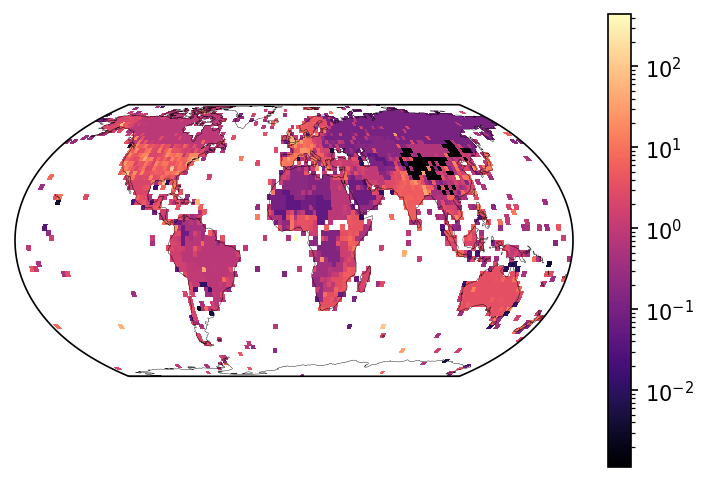

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines(lw=0.2)

shape = (len(study_grid_df.LAT.unique()), len(study_grid_df.LON.unique()))

n = np.array(study_grid_df.n).reshape(shape)

mesh=ax.pcolormesh(
    study_grid_df.LON.unique(), 
    study_grid_df.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma'),
    norm=mpl.colors.LogNorm(),
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)

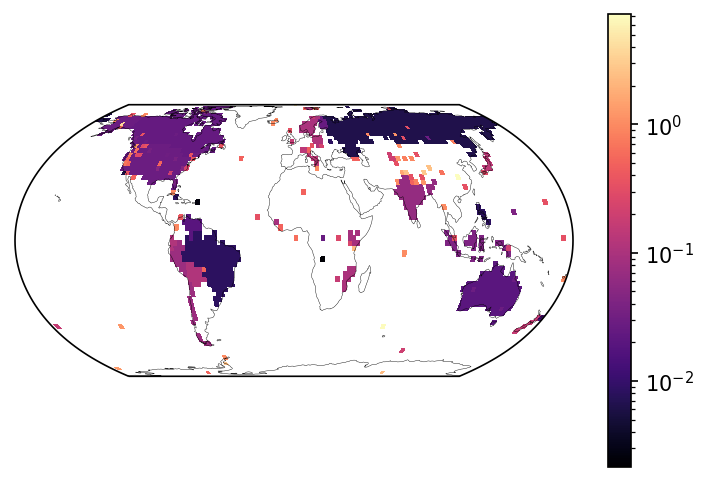

In [5]:
# If we want to map a subset of studies belonging to a particular class, we just need to feed this data into our function

study_grid_df = sum_studies(df[df["12 - Mountains, snow and ice"]>0.5], shp_df_matches, grid_df)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines(lw=0.2)

shape = (len(study_grid_df.LAT.unique()), len(study_grid_df.LON.unique()))

n = np.array(study_grid_df.n).reshape(shape)

mesh=ax.pcolormesh(
    study_grid_df.LON.unique(), 
    study_grid_df.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma'),
    norm=mpl.colors.LogNorm(),
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)